### Introduction 

 - #### This case study focuses on the issue of long waiting times in Hospital's emergancy room that effects patients experance and hospitals revenue by analying deffrinet wait times and patient's satisfaction due to it. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

### EDA

 - #### Starting by cleaning the data from null values and outlayers that can affect the analysis

In [58]:
### loading data
df = pd.read_csv("ER_wait.csv")
df.head(10)

,visit_id,patient_id,hospital_id,hospital_name,region,visit_date,day_of_week,season,time_of_day,urgency_level,nurse_to_patient_ratio,specialist_availability,facility_size,time_to_registration,time_to_triage,time_to_medical_professional,total_wait_time,patient_outcome,patient_satisfaction
0,HOSP-1-20240210-0001,PAT-00001,HOSP-1,Springfield General Hospital,Urban,2/10/2024 20:20,Saturday,Winter,Late Morning,Medium,4,3,92,17,22,66,105,Discharged,1
1,HOSP-3-20241128-0001,PAT-00002,HOSP-3,Northside Community Hospital,Rural,11/28/2024 2:07,Thursday,Fall,Evening,Medium,4,0,38,9,30,30,69,Discharged,3
2,HOSP-3-20240930-0002,PAT-00003,HOSP-3,Northside Community Hospital,Rural,9/30/2024 4:02,Monday,Fall,Evening,Low,5,1,38,38,40,125,203,Discharged,1
3,HOSP-2-20240227-0001,PAT-00004,HOSP-2,Riverside Medical Center,Urban,2/27/2024 0:31,Tuesday,Winter,Evening,High,4,5,94,8,16,64,88,Discharged,2
4,HOSP-1-20240306-0002,PAT-00005,HOSP-1,Springfield General Hospital,Urban,3/6/2024 16:52,Wednesday,Spring,Afternoon,Low,4,8,74,26,29,63,118,Discharged,1
5,HOSP-5-20241120-0001,PAT-00006,HOSP-5,Summit Health Center,Urban,11/20/2024 22:34,Wednesday,Fall,Night,Medium,3,7,167,12,15,36,63,Discharged,3
6,HOSP-3-20240221-0003,PAT-00007,HOSP-3,Northside Community Hospital,Rural,2/21/2024 15:26,Wednesday,Winter,Late Morning,Medium,4,2,42,22,37,57,116,Admitted,1
7,HOSP-2-20241212-0002,PAT-00008,HOSP-2,Riverside Medical Center,Urban,12/12/2024 20:23,Thursday,Winter,Afternoon,Medium,3,2,84,8,25,48,81,Admitted,2
8,HOSP-1-20241129-0003,PAT-00009,HOSP-1,Springfield General Hospital,Urban,11/29/2024 2:47,Friday,Fall,Afternoon,Medium,4,3,87,16,27,35,78,Discharged,2
9,HOSP-1-20240727-0004,PAT-00010,HOSP-1,Springfield General Hospital,Urban,7/27/2024 22:01,Saturday,Summer,Afternoon,Critical,1,4,99,3,3,5,11,Admitted,5


In [59]:

### checking data
print(df.info())
print(df.describe())
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   visit_id                      5000 non-null   object
 1   patient_id                    5000 non-null   object
 2   hospital_id                   5000 non-null   object
 3   hospital_name                 5000 non-null   object
 4   region                        5000 non-null   object
 5   visit_date                    5000 non-null   object
 6   day_of_week                   5000 non-null   object
 7   season                        5000 non-null   object
 8   time_of_day                   5000 non-null   object
 9   urgency_level                 5000 non-null   object
 10  nurse_to_patient_ratio        5000 non-null   int64 
 11  specialist_availability       5000 non-null   int64 
 12  facility_size                 5000 non-null   int64 
 13  time_to_registrati

- #### The data set shows a non-null 19 columns with 5,000 data point for each. Waiting time in all 5 hospitals have a mean of  81,std of 68 ,a max of  442, and min of 4 mins which is  a big range between the min and the max. also a small mean like 81 give us an intuition that most data points are small and reltivaly less than 80 mins but an std of 68 gives a sense of spreaded dataset

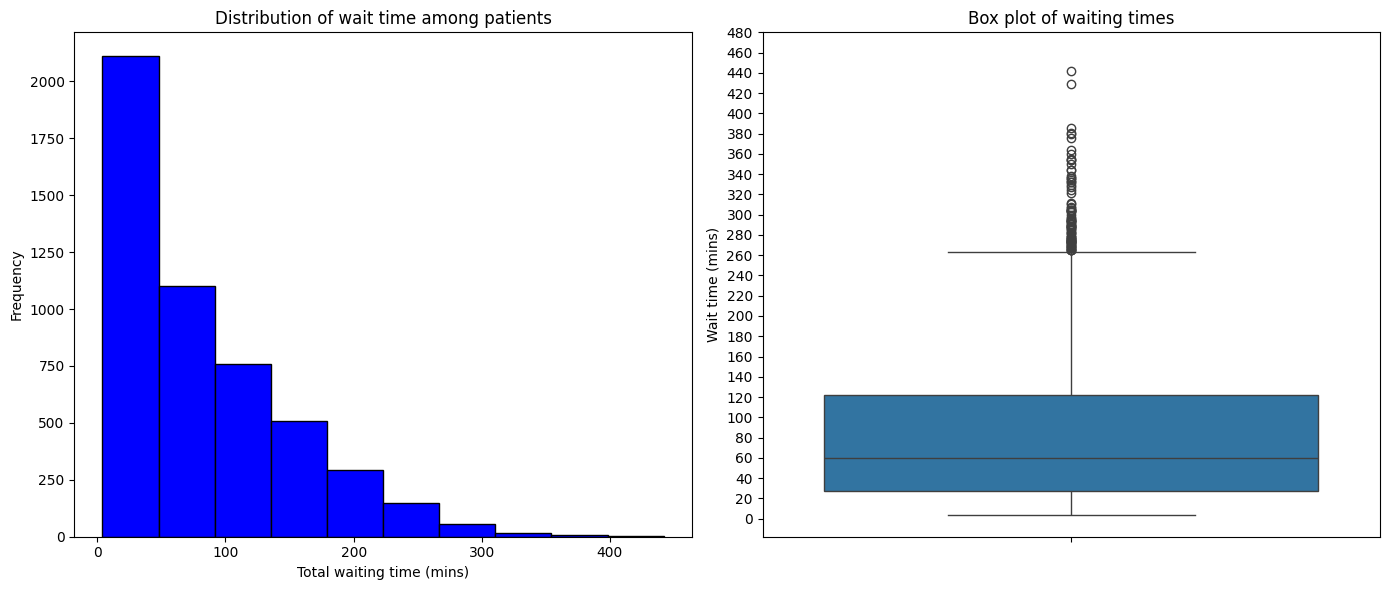

In [60]:
plt.figure(figsize=(14,6))
newticks = np.arange(0, 500, 20)
plt.subplot(1,2,1)
plt.hist(df['total_wait_time'], bins= 10, color='blue', edgecolor='black')
plt.title('Distribution of wait time among patients')
plt.xticks()
plt.xlabel('Total waiting time (mins)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(df['total_wait_time'])
plt.title('Box plot of waiting times')
plt.ylabel('Wait time (mins)')
plt.yticks(newticks)
plt.tight_layout()
plt.show()

- #### we clearly notice the vast majorty of the waiting times are less than 200 mints wich is still big number

In [61]:
df['total_wait_time'] = df['total_wait_time'].clip(upper = 265)

In [62]:
### validate and correct data types
df['visit_date'] = pd.to_datetime(df['visit_date'])

df['hour'] = df['visit_date'].dt.hour
df['month'] = df['visit_date'].dt.month_name()
df['date'] = df['visit_date'].dt.date


df.columns

Index(['visit_id', 'patient_id', 'hospital_id', 'hospital_name', 'region',
       'visit_date', 'day_of_week', 'season', 'time_of_day', 'urgency_level',
       'nurse_to_patient_ratio', 'specialist_availability', 'facility_size',
       'time_to_registration', 'time_to_triage',
       'time_to_medical_professional', 'total_wait_time', 'patient_outcome',
       'patient_satisfaction', 'hour', 'month', 'date'],
      dtype='object')

In [63]:
### quality flages
df['data_flag'] = 'clean'
df.loc[df['total_wait_time'] > 520, 'data_flag'] = 'outlaier_wait'


### data quality report
summary = {
    "total_rows": len(df),
    "missing_fixed": df.isnull().sum(),
    "outliers_flagged":(df['data_flag'] != 'clean').sum()
}
print(summary)

{'total_rows': 5000, 'missing_fixed': visit_id                        0
patient_id                      0
hospital_id                     0
hospital_name                   0
region                          0
visit_date                      0
day_of_week                     0
season                          0
time_of_day                     0
urgency_level                   0
nurse_to_patient_ratio          0
specialist_availability         0
facility_size                   0
time_to_registration            0
time_to_triage                  0
time_to_medical_professional    0
total_wait_time                 0
patient_outcome                 0
patient_satisfaction            0
hour                            0
month                           0
date                            0
data_flag                       0
dtype: int64, 'outliers_flagged': np.int64(0)}


In [64]:
### saving cleaned data
df.to_csv("cleanER.csv", index=False)

### Visualising the data

- #### In this part of the analysis we will visualize features vs wait time correlations and identify the features affecting the ttal waiting time

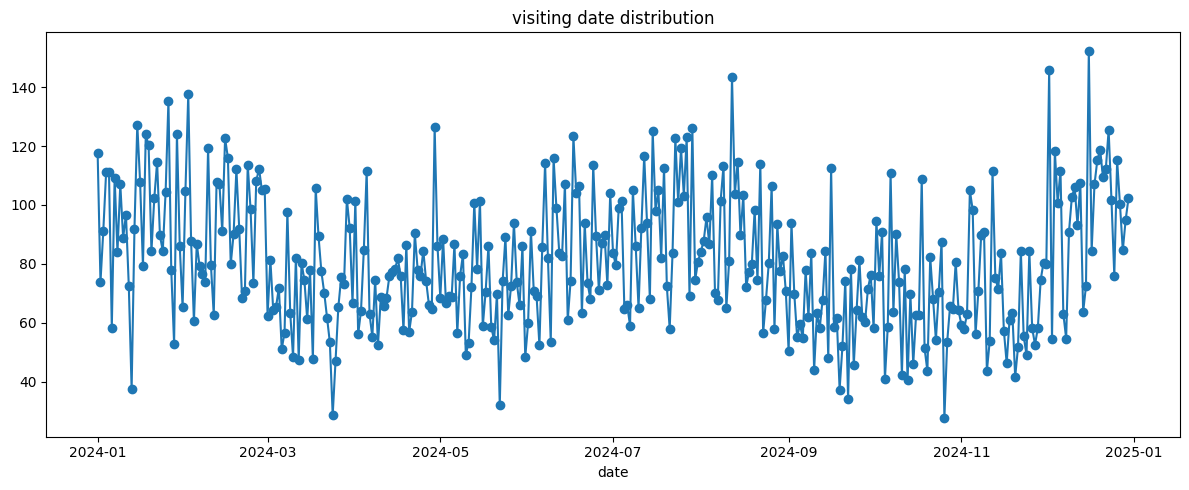

In [65]:
### visualizing

# line chart on visit date
plt.figure(figsize=(12, 5))
monthly_avg_time = df.groupby('date')['total_wait_time'].mean()
monthly_avg_time.plot(kind='line', marker='o')
plt.title('visiting date distribution')
plt.tight_layout()
plt.show()

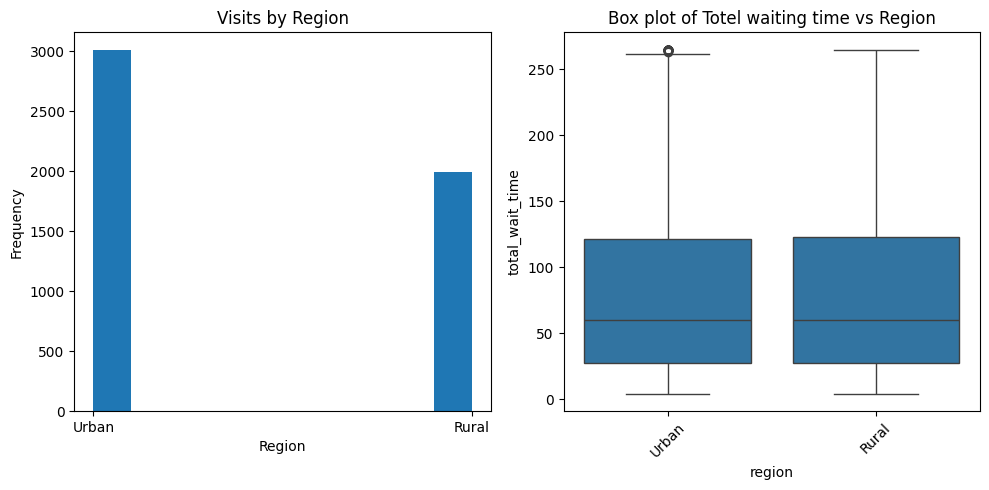

In [66]:

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(df['region'])
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Visits by Region')

plt.subplot(1,2,2)
sns.boxplot(data=df, x='region',y ='total_wait_time')
plt.title('Box plot of Totel waiting time vs Region')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

- #### The deffrince is very remarkable about 1.3 ratio more in urban than rural areas but with the same effect 

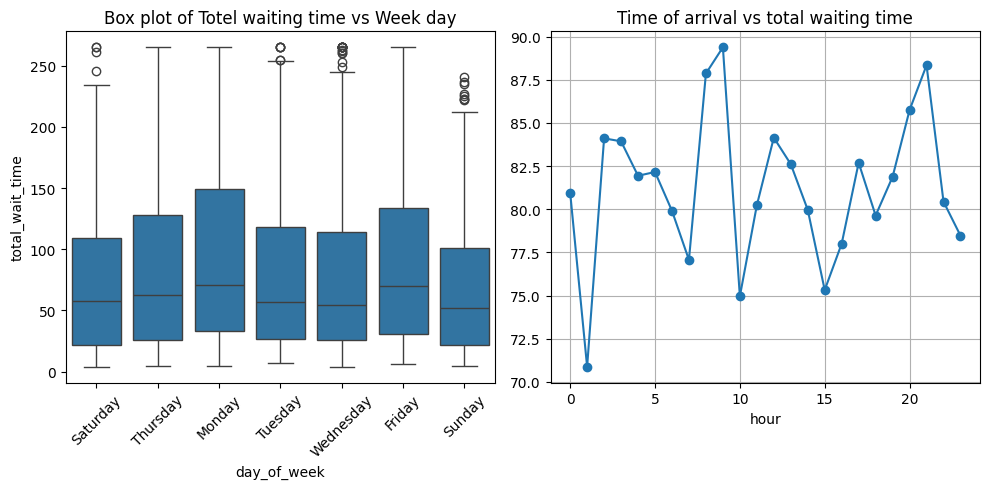

In [67]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(data=df, x='day_of_week',y ='total_wait_time')
plt.title('Box plot of Totel waiting time vs Week day')
plt.xticks(rotation=45)

arrival_hour_avg_time = df.groupby('hour')['total_wait_time'].mean()
plt.subplot(1,2,2)
arrival_hour_avg_time.plot(kind='line', marker='o')
plt.title('Time of arrival vs total waiting time')
plt.grid(True)
plt.tight_layout()
plt.show()

- #### Monday as we said above is an important factor for about 30 mins increasement of wait time in average succeeded by friday and thursday because most people favor thier medical visits to be in weekends or holidays, however hour of the day has a very narrow range of flactuations affecting waiting time

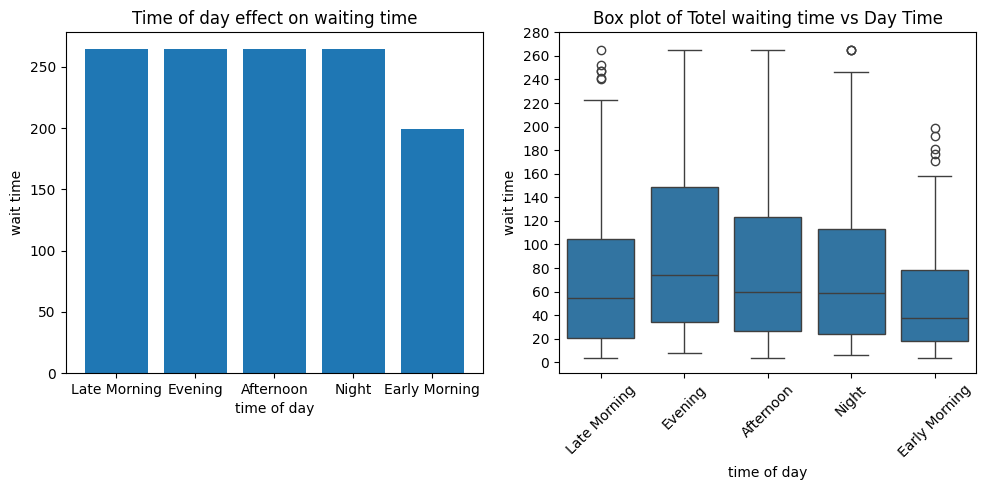

In [68]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(df['time_of_day'], df['total_wait_time'])
plt.xlabel('time of day')
plt.ylabel('wait time')
plt.title('Time of day effect on waiting time')

plt.subplot(1,2,2)
sns.boxplot(data=df, x='time_of_day',y ='total_wait_time')
plt.xlabel('time of day')
plt.ylabel('wait time')
plt.title('Box plot of Totel waiting time vs Day Time')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,300, 20))

plt.tight_layout()
plt.show()

- #### By the skew in the first plot it's obvios that most people wait less than 80 mins which is retivly big amont of time about ~ 3 hours which can result in alot of frustration and anger. which reflect in bad ratings and low revenue for the hospitls

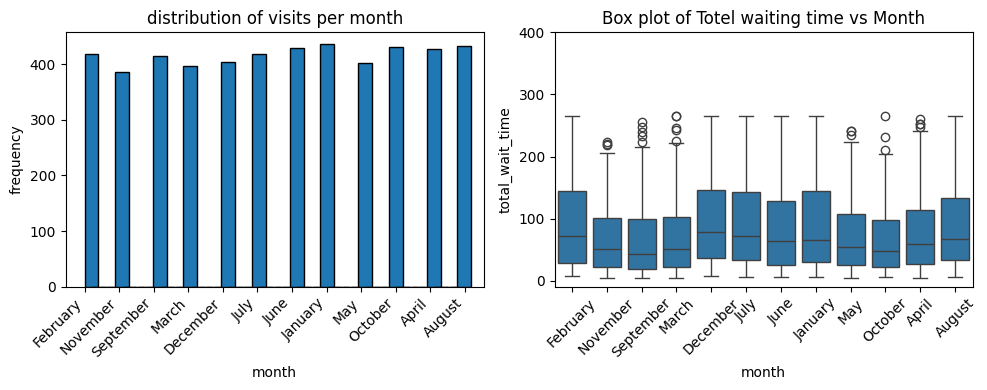

In [69]:
new_ticks = np.arange(0,500,100)

plt.figure(figsize = (10 , 4))
plt.subplot(1,2,1)
plt.hist(df['month'], bins = 50, edgecolor= 'black', width = 0.40)
plt.title('distribution of visits per month')
plt.xlabel('month')
plt.ylabel('frequency')
plt.xticks(rotation = 45, ha ='right')
plt.yticks(new_ticks)


plt.subplot(1,2,2)
sns.boxplot(data=df, x='month',y ='total_wait_time')
plt.title('Box plot of Totel waiting time vs Month')
plt.xticks(rotation=45)

plt.yticks(new_ticks)
plt.tight_layout()
plt.show()

 - #### The plot shows a distribution of total visits waiting time with peaks during the holidays which is resonable due to the decreasement of staff. We can see high variance daily 

 - #### in this histogram we see the average vists per month which looks steady and all above 350 visits. but looking at the distribution between regions meight affect the distribution and a varior effect on waiting time 

- #### we can say that people tend to laten thier hospital visits to the evening (after work) 

/tmp/ipykernel_100791/1648229355.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_time = df.groupby('month')['total_wait_time'].mean()


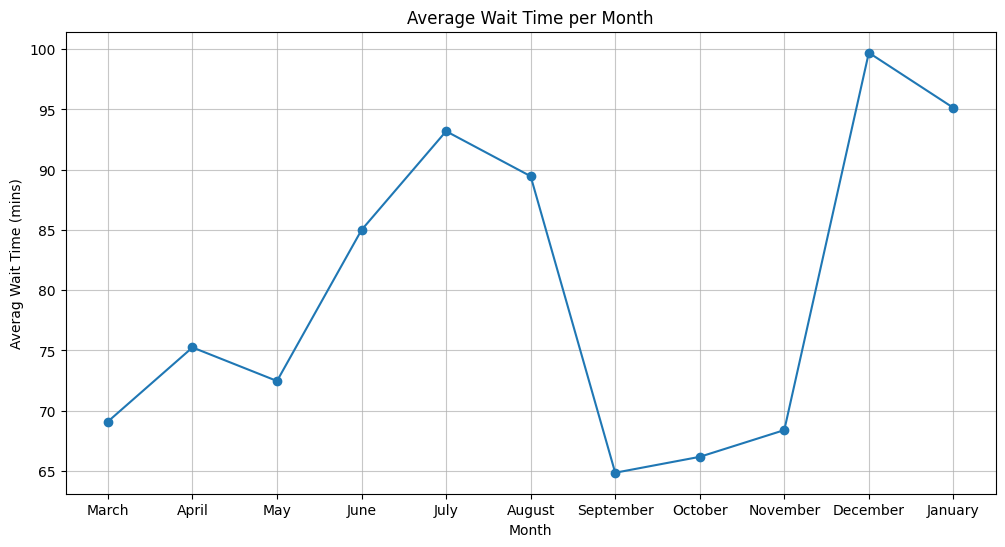

In [70]:
order = ['Febreuary','March','April','May','June','July','August','September','October','November','December','January']

df['month'] = pd.Categorical(df['month'], categories=order, ordered=True)
monthly_avg_time = df.groupby('month')['total_wait_time'].mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_avg_time, marker='o')
plt.title('Average Wait Time per Month')
plt.xlabel('Month')
plt.ylabel('Averag Wait Time (mins)')
plt.grid(True, alpha=0.7)
plt.show()


- #### we can see diffrent ups and downs in the months by avarage waiting time. a peak in summer and chrismas which is resonable because most of the staff will be having thier annual holiday from the receptionist to nurses to surgons  

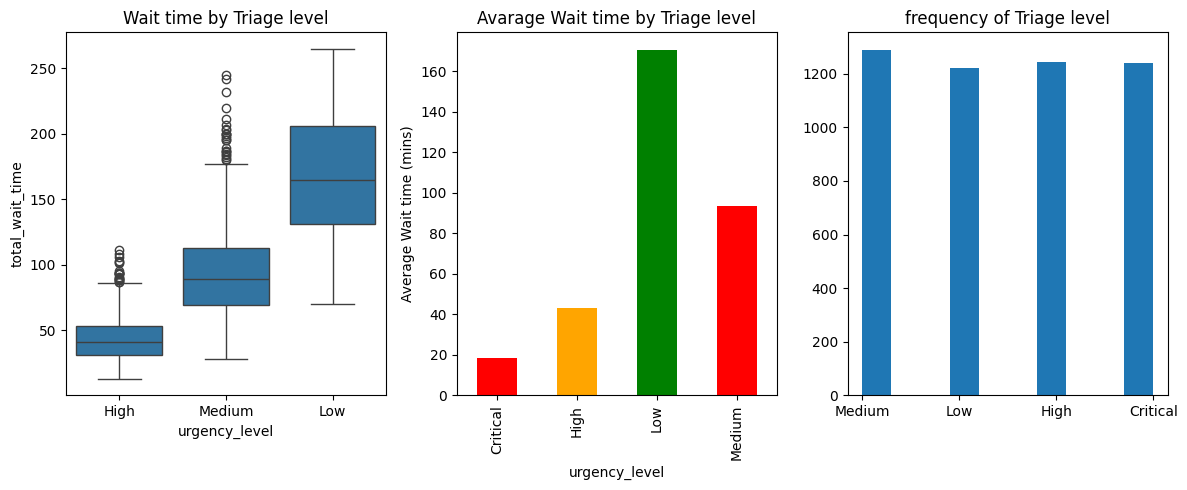

In [71]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
sns.boxplot(x=df['urgency_level'], y= df['total_wait_time'], order=['High','Medium','Low'])
plt.title('Wait time by Triage level')

plt.subplot(1,3,2)
triage_avg_time = df.groupby('urgency_level')['total_wait_time'].mean()
triage_avg_time.plot(kind='bar', color=['red','orange','green'])
plt.title('Avarage Wait time by Triage level')
plt.ylabel('Average Wait time (mins)')


plt.subplot(1,3,3)
plt.hist(df['urgency_level'])
plt.title('frequency of Triage level')


plt.tight_layout()
plt.show()


- #### Most patient with low urgency level takes more time in the ER up to 170 min on average and can reach up to 260 mins which is a big amount of time 3 hours and about 20 mins for critical cases and up to 45 mins for HIGH urgency level. this reveals a big issue.

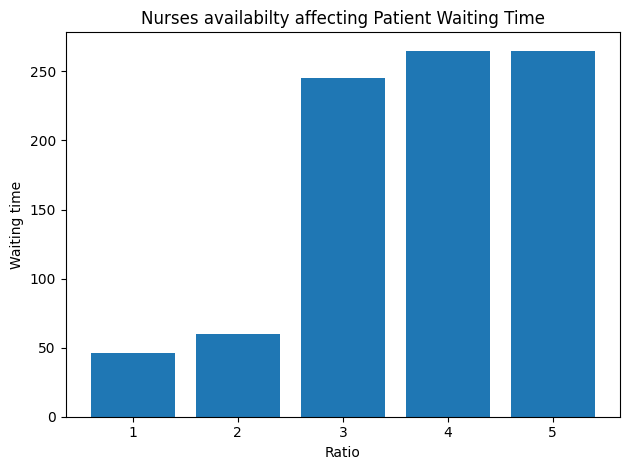

In [72]:
plt.bar(df['nurse_to_patient_ratio'], df['total_wait_time'])
plt.xlabel('Ratio')
plt.ylabel('Waiting time')
plt.title('Nurses availabilty affecting Patient Waiting Time')

plt.tight_layout()
plt.show()

- #### we clearly see the significance of nurses to speed up the prosses

# Regression analysis

In [73]:
df = pd.read_csv('cleanERdata.csv')
df['hour'] = pd.to_datetime(df['visit_date']).dt.hour

In [74]:
factors = df[['nurse_to_patient_ratio','urgency_level','time_of_day']]
factors = pd.get_dummies(factors ,drop_first = True).astype(np.int64)

In [75]:

Y = np.log1p(df['total_wait_time']).values
factors = sm.add_constant(factors)

model = sm.OLS(Y, factors)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5001.
Date:                Sun, 08 Feb 2026   Prob (F-statistic):               0.00
Time:                        05:45:33   Log-Likelihood:                -1129.8
No. Observations:                5000   AIC:                             2278.
Df Residuals:                    4991   BIC:                             2336.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.6638      0.017    160.047      0.000       2.631       2.696
nurse_to_patient_ratio        0.1481      0.009     17.228      0.000       0.131       0.165
urgency_level_High            0.5405      0.021     25.619      0.000       0.499       0.582
urgency_level_Low             1.7842      0.029     61.949      0.000       1.728       1.841
urgency_level_Medium          1.3154      0.021     63.051      0.000       1.274       1.356
time_of_day_Early Morning    -0.4101      0.016    -25.599      0.000      -0.442      -0.379
time_of_day_Evening           0.2134      0.011     19.906      0.000       0.192       0.234
time_of_day_Late Morning     -0.1999      0.013    -14.851      0.000      -0.226      -0.174
time_of_day_Night            -0.0811      0.015     -5.287      0.000      -0.111      -0.051
==============================================================================
Omnibus:                        7.965   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.848
Skew:                          -0.081   Prob(JB):                       0.0198
Kurtosis:                       2.894   Cond. No.                         34.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The OLS model we used explains 88.9% of the reasons for waiting time increasement and the rest be affected by the human errors. We can interpret the results as following :
1. nurse per patient ratio is the most effective variable in the equation though the low urgency level is the most important factor that can be controled
2. time of day also effects waiting time due to staff exhaustion and less attendace we see that early moring staff is 0.4 effective in reducing waiting time and evening staff of 0.2 increasement of waiting time
3. Low and medium urgency patients increase total waiting time by a coeffecient of 1.7 and 1.3 respectivly



## Residual analysis

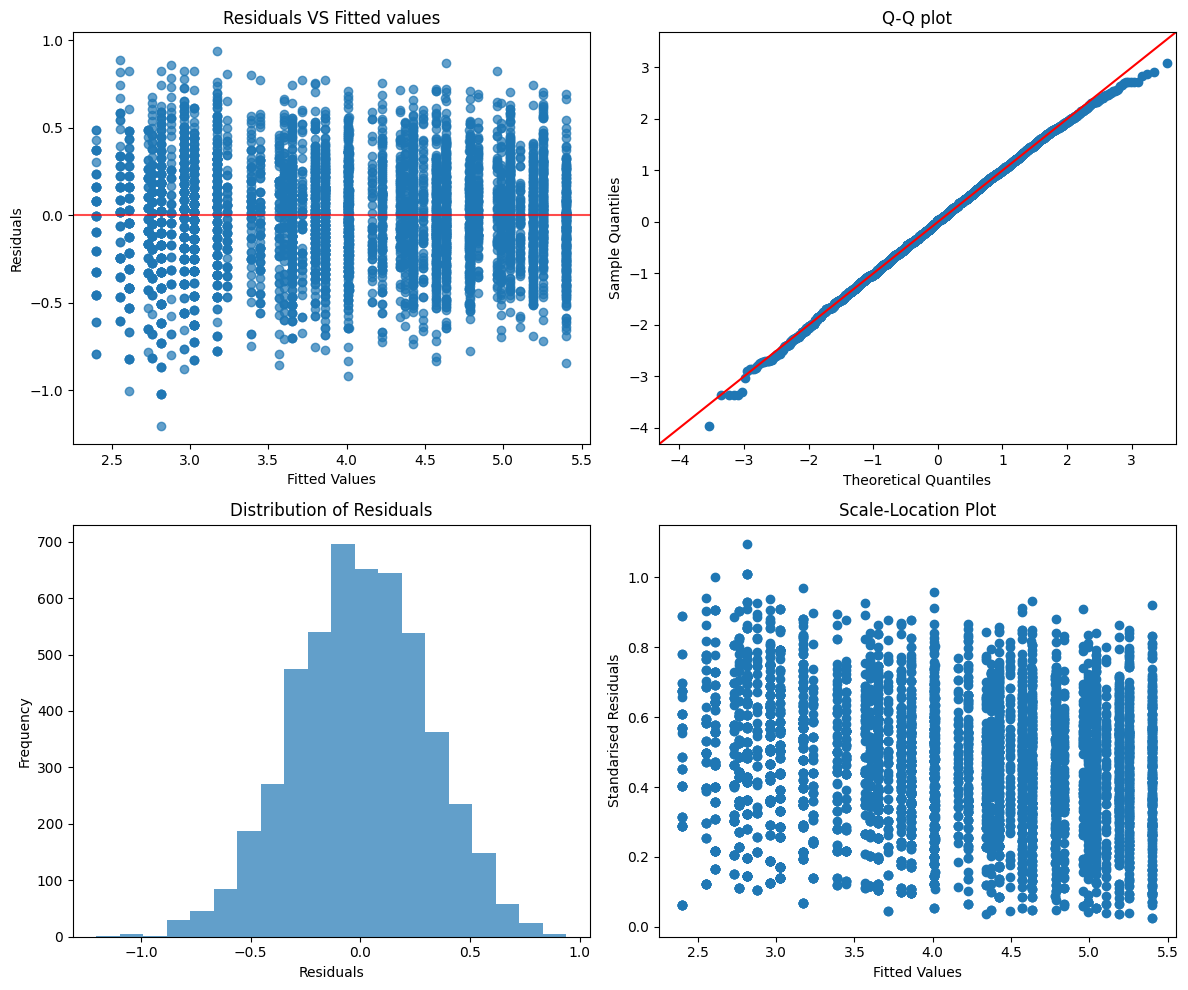

In [76]:
residuals = result.resid

fitted = result.fittedvalues


fig, axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].scatter(fitted,residuals, alpha =0.7)
axes[0,0].axhline(y=0,color='red', alpha =0.7)
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals VS Fitted values')


sm.qqplot(residuals, line ='45',ax = axes[0,1], fit = True)
axes[0,1].set_title('Q-Q plot')


axes[1,0].hist(residuals, bins = 20 , alpha=0.7)
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')


axes[1,1].scatter(fitted, np.sqrt(np.abs(residuals)))
axes[1,1].set_xlabel('Fitted Values')
axes[1,1].set_ylabel('Standarised Residuals')
axes[1,1].set_title('Scale-Location Plot')





plt.tight_layout()
plt.show()

- #### The vetical stipes show up because we are using disctret and catigorical values 

### Patient satisfaction Predictions

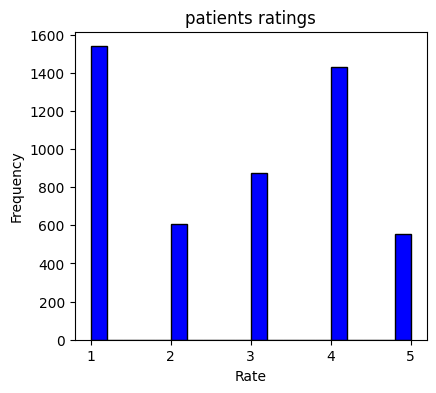

In [77]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df['patient_satisfaction'], bins= 20, color='blue', edgecolor='black')
plt.title('patients ratings')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()

- #### We can see that 5 and 2 stars have less ocurrance than other ratings like 1 and 4

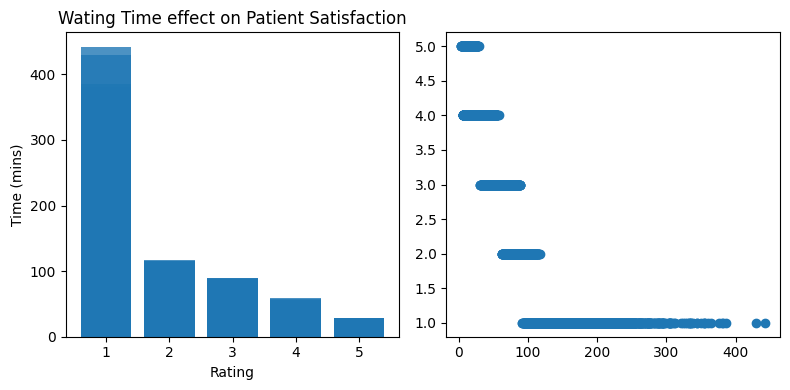

In [78]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.bar(df['patient_satisfaction'], df['total_wait_time'], label = 'total waiting time', alpha = 0.8)
plt.xlabel('Rating')
plt.ylabel('Time (mins)')
plt.title('Wating Time effect on Patient Satisfaction')

plt.subplot(1,2,2)
plt.scatter(df['total_wait_time'], df['patient_satisfaction'])




plt.tight_layout()
plt.show()

- #### we see that patient satiefaction is highly affected by waitng time though ratings overlap sometimes due to peersonal experiance and othe personal factors

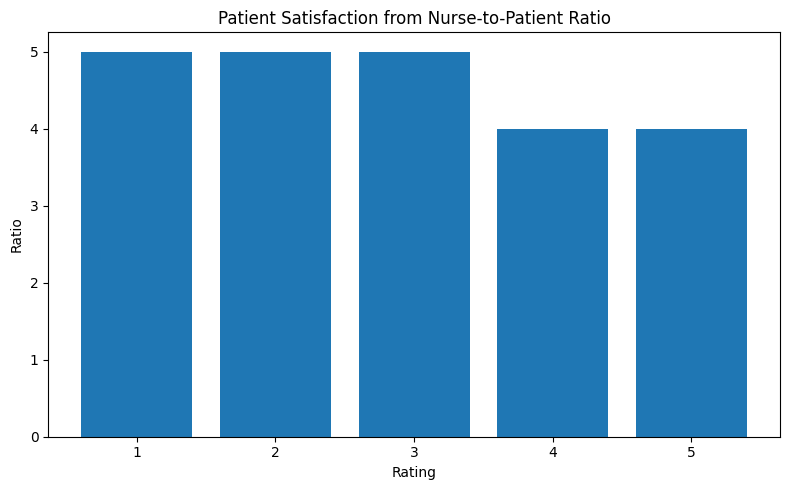

In [79]:
plt.figure(figsize=(8,5))
plt.bar(df['patient_satisfaction'], df['nurse_to_patient_ratio'], label = 'total waiting time', alpha = 0.8)


plt.xlabel('Rating')
plt.ylabel('Ratio')
plt.title('Patient Satisfaction from Nurse-to-Patient Ratio')
plt.tight_layout()
plt.show()

- #### it's also slitly affected by nurse per patient ratio because it affect cuality of service and waiting time

In [80]:
# encoding the deffrient labels
factors = df
le = LabelEncoder()

for i in df.columns:
    factors[i] = le.fit_transform(df[i])

factors.dtypes

visit_id                        int64
patient_id                      int64
hospital_id                     int64
hospital_name                   int64
region                          int64
visit_date                      int64
day_of_week                     int64
season                          int64
time_of_day                     int64
urgency_level                   int64
nurse_to_patient_ratio          int64
specialist_availability         int64
facility_size                   int64
time_of_registration            int64
time_to_triage                  int64
time_of_medical_professional    int64
total_wait_time                 int64
patient_outcome                 int64
patient_satisfaction            int64
time                            int64
month                           int64
date                            int64
patient_number                  int64
data_flag                       int64
hour                            int64
dtype: object

In [81]:

X = factors.drop(columns='patient_satisfaction')
Y = df['patient_satisfaction']

# Spliting data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)


# Model fitting
rate_model = RandomForestClassifier(random_state= 1 )
results = rate_model.fit(X_train,Y_train)

# Prediction
Y_pred = rate_model.predict(X_test)

# Model evaluation
print(' == accuracy == ', accuracy_score(Y_test,Y_pred))
print('== classification report ==\n ', classification_report(Y_test,Y_pred))
print('== confusion matrix ==\n ',confusion_matrix(Y_test, Y_pred))

 == accuracy ==  0.787
== classification report ==
                precision    recall  f1-score   support

           0       0.96      0.96      0.96       303
           1       0.71      0.78      0.74       108
           2       0.78      0.73      0.75       183
           3       0.72      0.77      0.74       292
           4       0.57      0.48      0.52       114

    accuracy                           0.79      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.79      0.79      0.79      1000

== confusion matrix ==
  [[290  13   0   0   0]
 [ 12  84  12   0   0]
 [  0  21 133  29   0]
 [  0   0  26 225  41]
 [  0   0   0  59  55]]


#### The classifier made a 78.7% accuracy on the dataset which is very prommising but it can not be more accurate wihout overfitting the data due to the following:
1. Ratings data are very unpredictable because it is very dependent on people feelings rather than pure logic
2. Most of the misclassified data points were because of the distribution of the ratings most of them as we saw above are polarizered with means that most people ted to rate by either 1 or 4 rather than logicly copying thier fair view



# Conclusion

#### What can be done:
- hiring new nurses would be expencive for small clincs .However, it would make a great effect on patient care and satisfaction
- for small clincs it can start by making a moonligghting programm with temporary workers or engage interns
- it might also use AI for more productive work but it should be reviewed by a physician
